# COVID-19 X-rays Classifier tutorial 

COVID-19


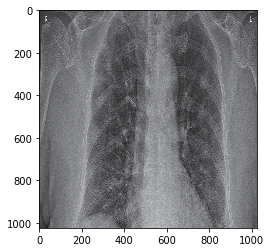

1024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
from os import walk
DATADIR = "COVID-19 Radiography Database"


f = []
for (dirpath, dirnames, filenames) in walk(DATADIR):
    f.extend(dirnames)
    break

for category in f:
    print(category)
    path = os.path.join(DATADIR,category) 
    for img in os.listdir(path): 
        img_array = cv2.imread(os.path.join(path,img))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        plt.imshow(img_array) 
        plt.show() 

        break 
    break
img_array.shape[0]

## 1) Load the Data

The Chest X-ray data we are using divides the data into 3 folders (COVID-19,NORMAL,Viral Pneumonia)
so we read the images from every folder and give a label that represent it and also reshape the images from  1080 to 224

In [2]:
training_data = []
IMG_SIZE=224
def create_training_data():
    for category in f: 

        path = os.path.join(DATADIR,category) 
        for img in tqdm(os.listdir(path)): 
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
                training_data.append([new_array, category]) 
            except Exception as e: 
                pass


create_training_data()

print(len(training_data))

100%|██████████████████████████████████████████████████████████████████████████████| 1345/1345 [00:54<00:00, 24.85it/s]

2905


Shuffle the data after reading  it so the model can learn and don't overfit over one class

In [3]:
import random

random.shuffle(training_data)

In [4]:
for sample in training_data[:10]: # see a sample of the labels
    print(sample[1])

Viral Pneumonia
COVID-19
Viral Pneumonia
Viral Pneumonia
Viral Pneumonia
NORMAL
COVID-19
Viral Pneumonia
NORMAL
NORMAL


In [5]:
print(len(training_data)) # the number of images we extracted

2905


## 2) Visualize the dataset

In [5]:
def show_batch(image_batch,label_batch): # see a batch of  the  data to better understand it
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n], cmap='gray')
        plt.title(label_batch[n])
        plt.axis("off")

In [6]:
def show_batch_predicted(image_batch): # see the same batch after prediction from the model
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n], cmap='gray')
        pred=model.predict(np.array(image_batch[n]).reshape(1, IMG_SIZE, IMG_SIZE, 1))
        label=np.argmax(pred,axis=1)
        if label[0] == 0:
            plt.title('COVID-19')
        elif label[0] == 1:
            plt.title('Normal')
        elif label[0] == 2:
            plt.title('Viral Pneumonia')
        plt.axis("off")

now we prepare the data for the training by converting the images to an array and convert the labels to 3 binary code that represent the classes 

(2905, 1)
[['Viral Pneumonia']
 ['COVID-19']
 ['Viral Pneumonia']
 ...
 ['NORMAL']
 ['NORMAL']
 ['Viral Pneumonia']]
(2905, 3) (2905, 224, 224, 1)


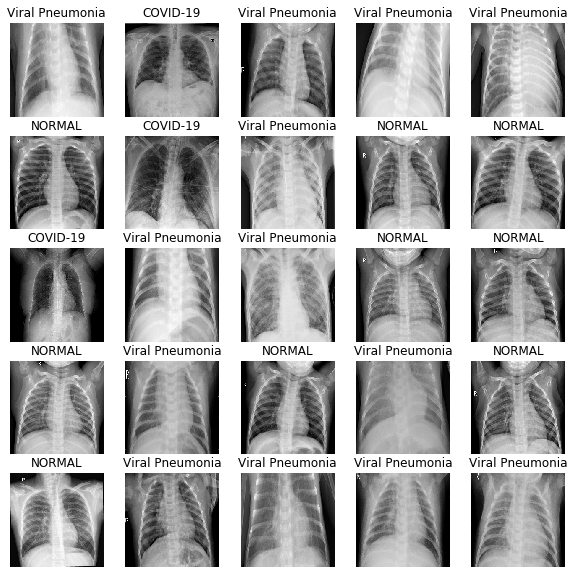

In [8]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)
show_batch(X,y)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y=np.array(y).reshape(-1, 1)
print(y.shape)
print(y)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

y=to_categorical(y)
print(y.shape,X.shape)

## 3) Correct for data imbalance

Lets see the number of images of every class

In [9]:
counts=[]
for i in range(3):
    counts.append(y[:,i].astype(bool).sum(axis=0))
counts

[219, 1341, 1345]

now we have the problem that the classes is not balanced so the model may just predict the class that have more images without learning.
so we need to set the classes weights 

In [10]:
for i in range (3):
    counts[i] = (1 / counts[i])*(len(X))/3.0 

print(counts)
class_weight = {0: counts[0], 1: counts[1], 2: counts[2]}

[4.421613394216133, 0.7220979368630375, 0.7199504337050806]


## 4) Split the training data

now we will split the training data into train(80%) and test(20%)

In [13]:
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## 5) Build the CNN

In [10]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Convolution2D,SeparableConv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import Input, Lambda, Conv2D, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, Input, Add
from keras.models import load_model, Model
# from keras.layers.merge import add

In [11]:
def conv_block(clf,filters,kernel_size,skip=True):
    for i in range(2):
        clf=SeparableConv2D(filters=filters, kernel_size=kernel_size, padding='same')(clf)
        clf=BatchNormalization(epsilon=0.001)(clf)
        clf=LeakyReLU(alpha=0.1)(clf)
    
    skip_connection = clf
    for i in range(2):
        clf=SeparableConv2D(filters=filters, kernel_size=kernel_size, padding='same')(clf)
        clf=BatchNormalization(epsilon=0.001)(clf)
        clf=LeakyReLU(alpha=0.1)(clf)
    
    return Add()([skip_connection, clf]) if skip else clf

def dense_block(clf,units, dropout_rate):
    
    clf=Dense(units,activation='relu')(clf)
    clf=BatchNormalization(epsilon=0.001)(clf)
    clf=Dropout(dropout_rate)(clf)
    
    return clf

In [15]:
def build_model():
    input_image = Input(shape=X_train.shape[1:])
    clf=Convolution2D(filters=16, kernel_size=3, padding='same')(input_image)
    clf=Convolution2D(filters=16, kernel_size=3, padding='same')(clf)
    clf=MaxPooling2D(pool_size=2)(clf)
    clf=conv_block(clf,32,3)
    clf=MaxPooling2D(pool_size=2)(clf)
    
    clf=conv_block(clf,64,3)
    clf=MaxPooling2D(pool_size=2)(clf)
    
    clf=conv_block(clf,128,3)
    clf=MaxPooling2D(pool_size=2)(clf)
    clf=Dropout(.2)(clf)
    
    clf=conv_block(clf,256,3)
    clf=MaxPooling2D(pool_size=2)(clf)
    clf=Dropout(.2)(clf)
    
    clf=conv_block(clf,256,3)
    clf=MaxPooling2D(pool_size=2)(clf)
    clf=Dropout(.2)(clf)
    
    clf=Flatten()(clf)
    clf=dense_block(clf,2304, 0.3)
    clf=dense_block(clf,512, 0.3)
    clf=dense_block(clf,128, 0.3)
    
    clf=Dense(3, activation='softmax')(clf)

    return Model(input_image,clf)
model=build_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 224, 224, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 224, 224, 16) 2320        conv2d_3[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 112, 112, 16) 0           conv2d_4[0][0]                   
____________________________________________________________________________________________

## 6) Train the model

In [91]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping,LearningRateScheduler


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


checkpoint_cb = ModelCheckpoint("Covid_model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max', period=1)


def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = LearningRateScheduler(exponential_decay_fn)

history = model.fit(
    X_train,y_train,
    epochs=100, batch_size=32,
    validation_split=.2,verbose=1, shuffle=True,
    callbacks=[checkpoint_cb, lr_scheduler],
    class_weight=class_weight
)

Train on 1859 samples, validate on 465 samples
Epoch 1/100
1859/1859 [==============================] - 39s 21ms/step - loss: 0.9777 - accuracy: 0.6417 - val_loss: 4.4285 - val_accuracy: 0.4839
Epoch 2/100
1859/1859 [==============================] - 21s 11ms/step - loss: 0.5468 - accuracy: 0.7800 - val_loss: 1.7772 - val_accuracy: 0.4323
Epoch 3/100
1859/1859 [==============================] - 21s 11ms/step - loss: 0.4064 - accuracy: 0.8284 - val_loss: 1.4397 - val_accuracy: 0.4925
Epoch 4/100
1859/1859 [==============================] - 21s 11ms/step - loss: 0.2989 - accuracy: 0.8731 - val_loss: 2.1796 - val_accuracy: 0.1333
Epoch 5/100
1859/1859 [==============================] - 21s 11ms/step - loss: 0.3151 - accuracy: 0.8822 - val_loss: 0.5530 - val_accuracy: 0.7828
Epoch 6/100
1859/1859 [==============================] - 21s 11ms/step - loss: 0.3351 - accuracy: 0.8731 - val_loss: 1.2173 - val_accuracy: 0.2000
Epoch 7/100
1859/1859 [==============================] - 21s 11ms/step 

## 7) Visualizing model performance

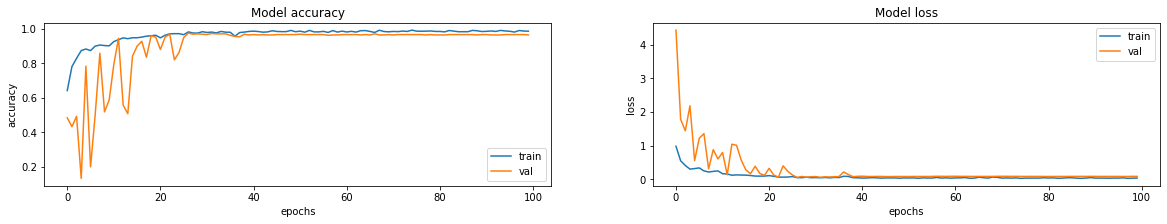

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## 8) Predict and evaluate results

In [93]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100)

581/581 [==============================] - 1s 2ms/step
Test loss: 0.13009443733017256
Test accuracy: 96.55765891075134


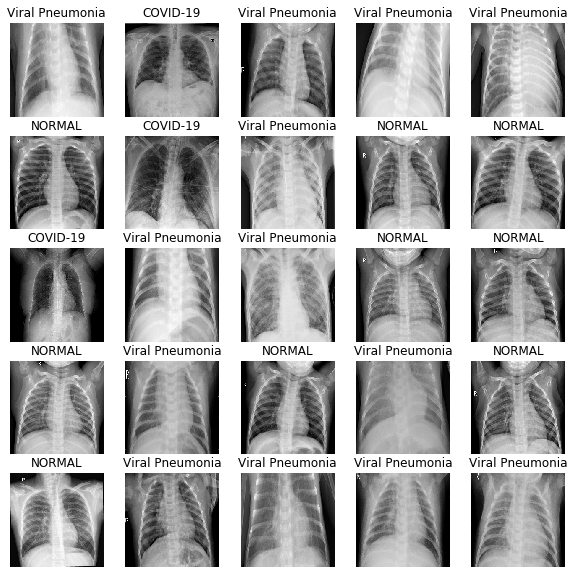

In [17]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)
show_batch(X,y)

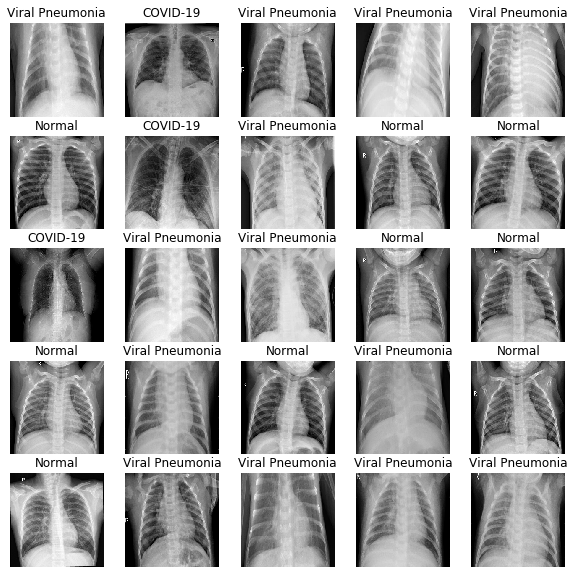

In [19]:
show_batch_predicted(X)